In [4]:
using Distributed
addprocs(8)

8-element Array{Int64,1}:
 2
 3
 4
 5
 6
 7
 8
 9

In [7]:
@everywhere using Pkg
@everywhere Pkg.activate(".")

In [103]:
using Plots
pyplot()

using LaTeXStrings
using Statistics
using StatsBase
using Random

@everywhere include("fluo_cont_meas_sim.jl")
@everywhere include("likelihood.jl")
@everywhere include("likelihood_strong.jl")
@everywhere include("likelihood_strong_internal.jl")
@everywhere include("likelihood_strong_everystep.jl")
@everywhere include("fisher_cont_meas.jl")

In [26]:
@everywhere begin
# Experimental parameters
T1 = 15.0
TD = 5.0
Trabi = 2.
Tphi = 17.9

NTrajectories = 500

# Parameter dictionary to be passed to the functions
params = Dict( :Tfinal    => 20., # Final time
               :dt        => 0.1, # duration of infinitesimal time
               :Gamma1    => 1. / T1,   # Gamma fluoresence
               :GammaD    => 1. / TD,  # Gamma dephasing controllable
               :GammaPhi  => 1. / Tphi,  # Gamma dephasing not controllable
               :etavalF   => 0.14, # efficiency fluoresence heterodyne
               :etavalD   => 0.34, # efficiency dephasing homodyne
               :omegaTrue => 2 * pi / Trabi, # True value of omega
               :omegaMin  => 2., # minimum value of omega
               :omegaMax  => 4., # maximum value of omega
               :threshold => 0.375,
               :Nomega    => 500); # Resolution in omega for the Bayesian estimation
end

We now check that the estimation works with the simulated experiment

In [104]:
@time simData = parallel_fluo_continuous_measurement_het_simulation(NTrajectories; params...) 
@time simRes = Likelihood_strong(simData.dyHet1, simData.dyHet2, simData.dyDep, simData.OutStrong, 200; 
        internalsteps = 1, params...);

  2.402401 seconds (2.74 M allocations: 131.997 MiB, 10.27% gc time)
 16.350735 seconds (53.90 M allocations: 6.302 GiB, 15.75% gc time)


┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = py_add_series(::Plots.Plot{Plots.PyPlotBackend}, ::Plots.Series) at pyplot.jl:823
└ @ Plots /home/qtech/.julia/packages/Plots/UQI78/src/backends/pyplot.jl:823
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = py_add_legend(::Plots.Plot{Plots.PyPlotBackend}, ::Plots.Subplot{Plots.PyPlotBackend}, ::PyCall.PyObject) at pyplot.jl:1247
└ @ Plots /home/qtech/.julia/packages/Plots/UQI78/src/backends/pyplot.jl:1247


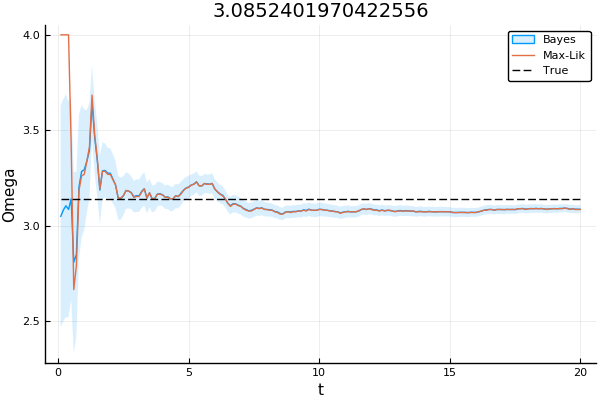

In [105]:
let res = simRes
    plot(res.t, res.omegaEst, ribbon=(res.sigmaBayes, res.sigmaBayes), fillalpha=0.15, label="Bayes")
    xlabel!("t")
    ylabel!("Omega")
    plot!(res.t, res.omegaMaxLik, label="Max-Lik")
    plot!(res.t, fill(params[:omegaTrue], size(res.t)), style=:dash, color=:black, label="True")
    title!(string(res.omegaEst[end]))
end

In [15]:
include("likelihood_strong.jl")
@time simRes_internal = Likelihood_strong_internal(simData.dyHet1, simData.dyHet2, simData.dyDep, simData.OutStrong, 200; 
        internalsteps = 10, params...);

 76.242009 seconds (105.32 M allocations: 10.151 GiB, 4.51% gc time)


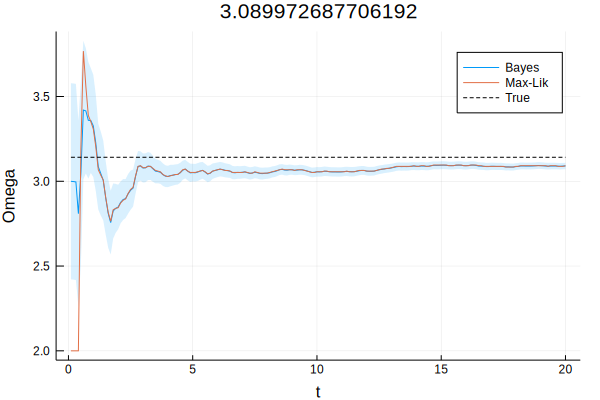

In [16]:
let res = simRes_internal
    plot(res.t, res.omegaEst, ribbon=(res.sigmaBayes, res.sigmaBayes), fillalpha=0.15, label="Bayes")
    xlabel!("t")
    ylabel!("Omega")
    plot!(res.t, res.omegaMaxLik, label="Max-Lik")
    plot!(res.t, fill(params[:omegaTrue], size(res.t)), style=:dash, color=:black, label="True")
    title!(string(res.omegaEst[end]))
end

In [17]:
include("likelihood_strong_everystep.jl")
@time simRes_internal_every = Likelihood_strong_everystep(simData.dyHet1, simData.dyHet2, simData.dyDep, simData.OutStrong, 200; 
        internalsteps = 10, params...);

581.150402 seconds (9.13 G allocations: 467.124 GiB, 25.34% gc time)


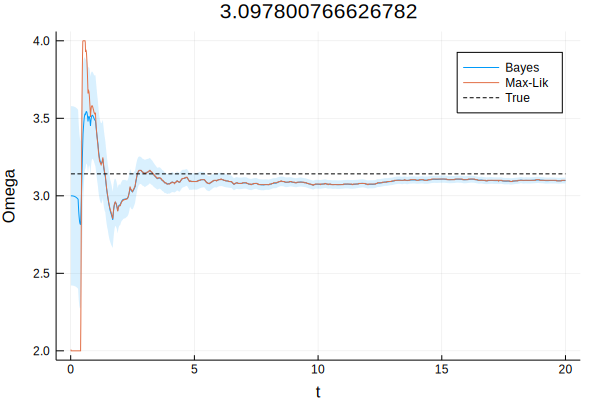

In [18]:
let res = simRes_internal_every
    plot(res.t, res.omegaEst, ribbon=(res.sigmaBayes, res.sigmaBayes), fillalpha=0.15, label="Bayes")
    xlabel!("t")
    ylabel!("Omega")
    plot!(res.t, res.omegaMaxLik, label="Max-Lik")
    plot!(res.t, fill(params[:omegaTrue], size(res.t)), style=:dash, color=:black, label="True")
    title!(string(res.omegaEst[end]))
end

## Let's compare the Fisher information with our Bayesian variance

In [13]:
params_unconditional = copy(params)
params_unconditional[:etavalF] = 0.
params_unconditional[:etavalD] = 0.

#(tFisher, FisherAvgUncOmega15, QFisherAvgUncOmega15, FisherMAvgUncOmega15, QFisherEffUNCOmega15, FisherMEffUNCOmega15)
@time fisherUncResult = parallel_fluo_continuous_measurement_het_classic_initial0(10; Ntime=1000, params_unconditional...)
@time fisherResult = parallel_fluo_continuous_measurement_het_classic_initial0(5000; Ntime=1000, params...);

  6.882477 seconds (9.67 M allocations: 501.458 MiB, 7.35% gc time)
105.666229 seconds (477.32 M allocations: 41.877 GiB, 11.59% gc time)


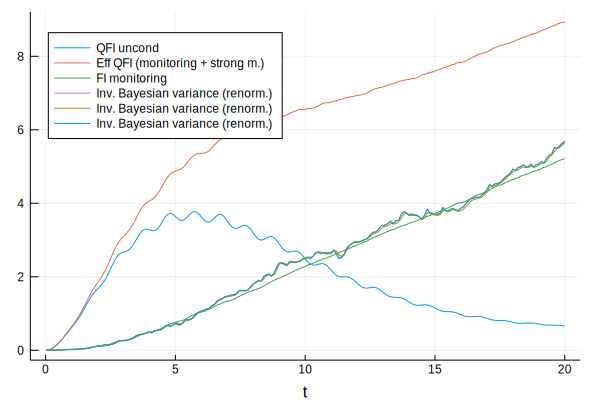

In [19]:
plot(fisherUncResult.t, fisherUncResult.QFisherEff, label="QFI uncond", legend=:topleft)
plot!(fisherResult.t, fisherResult.QFisherEff, label="Eff QFI (monitoring + strong m.)")
plot!(fisherResult.t, fisherResult.FisherAvg, label="FI monitoring")
plot!(simRes.t, simRes.sigmaBayes .^ -2 ./ NTrajectories, label="Inv. Bayesian variance (renorm.)")
plot!(simRes_internal.t, simRes_internal.sigmaBayes .^ -2 ./ NTrajectories, label="Inv. Bayesian variance (renorm.)")
plot!(simRes_internal_every.t, simRes_internal_every.sigmaBayes .^ -2 ./ NTrajectories, label="Inv. Bayesian variance (renorm.)")
xlabel!("t")

## Other $\Omega$s

  0.052778 seconds (7.58 k allocations: 315.906 KiB)
  4.109361 seconds (12.10 M allocations: 1.317 GiB, 12.77% gc time)


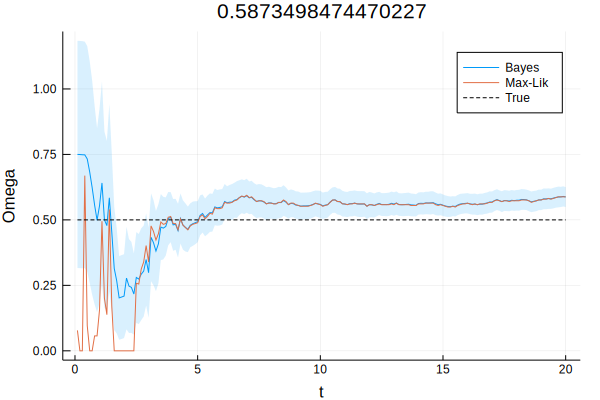

In [20]:
params[:omegaTrue] = .5
params[:omegaMin] = max(0, params[:omegaTrue] - 1)
params[:omegaMax] = params[:omegaTrue] + 1
@time simData = parallel_fluo_continuous_measurement_het_simulation(100; params...) 
@time simRes = Likelihood_strong(simData.dyHet1, simData.dyHet2, simData.dyDep, simData.OutStrong, 200; 
        internalsteps = 1, params...);

plot( simRes.t, simRes.omegaEst, ribbon=(simRes.sigmaBayes, simRes.sigmaBayes), fillalpha=0.15, label="Bayes")
xlabel!("t")
ylabel!("Omega")
plot!(simRes.t, simRes.omegaMaxLik, label="Max-Lik")
plot!(simRes.t, fill(params[:omegaTrue], size(simRes.t)), style=:dash, color=:black, label="True")
title!(string(simRes.omegaEst[end]))

In [27]:
@everywhere function vsomega(omega, Ntrajectories, initialparams)
    params = copy(initialparams)
    params[:omegaTrue] = omega
    params[:omegaMin] = max(0, params[:omegaTrue] - 1)
    params[:omegaMax] = params[:omegaTrue] + 1
    simData = parallel_fluo_continuous_measurement_het_simulation(Ntrajectories; params...) 
    simRes = Likelihood_strong(simData.dyHet1, simData.dyHet2, simData.dyDep, simData.OutStrong, 200; params...);
    return simRes.omegaEst[end], simRes.sigmaBayes[end]
end

# Basic linear regression
linreg(x, y) = reverse([x ones(length(x))] \ y)

In [49]:
using Random
omegasR = rand(0.25:0.00001:3, 100)
@time resR = pmap(o -> vsomega(o, 500, params), omegasR, batch_size=10)

763.315100 seconds (242.64 k allocations: 11.543 MiB, 0.01% gc time)


100-element Array{Tuple{Float64,Float64},1}:
 (2.197352887523283, 0.022964343877678744)  
 (0.7694713771369033, 0.01962630313077794)  
 (1.6308084002615395, 0.018617469132274442) 
 (1.4726819821875048, 0.01841278624535135)  
 (0.5632564779862856, 0.018692040639340553) 
 (1.847647803105907, 0.020333998859922573)  
 (2.059073664210171, 0.02024830512680001)   
 (0.28447979391022693, 0.012648172775672664)
 (1.587684953707997, 0.01924848819899154)   
 (0.7353404204644098, 0.019981913988201504) 
 (1.0183625424824492, 0.018609685127965958) 
 (2.8664661253242407, 0.019488889220726877) 
 (1.213307209161137, 0.01881612025723689)   
 ⋮                                          
 (2.6210206080018503, 0.021626864642966214) 
 (2.6084095509306024, 0.018149332124986553) 
 (2.473130784580183, 0.02518821805829593)   
 (0.3183903415439213, 0.013981581872832369) 
 (2.054719494367822, 0.02198894436661686)   
 (1.9121767606626032, 0.019748601810399644) 
 (2.1657063859945564, 0.018259044236498285) 
 (0.429040

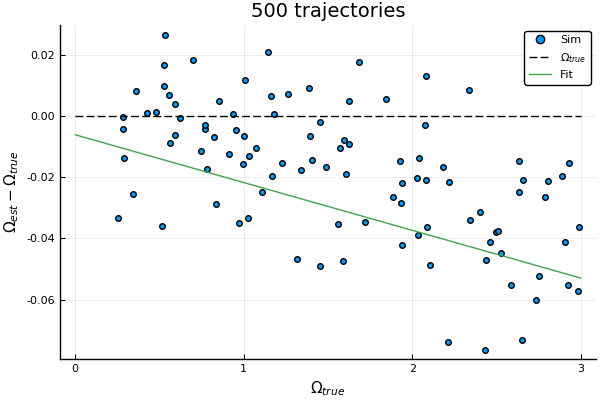

In [92]:
processedR = collect.(collect(zip(resR...)))
coeff = linreg(omegasR, processedR[1] - omegasR)
scatter(omegasR, (processedR[1] .- omegasR), label="Sim")
plot!([0,3],[0,0], style=:dash, color=:black, label=L"\Omega_{true}")
plot!([0,3], coeff[2] .* [0,3] .- coeff[1], label="Fit")
xlabel!(L"\Omega_{true}")
ylabel!(L"\Omega_{est}- \Omega_{true}")
title!("500 trajectories")

In [94]:
omegasR1000 = rand(0.25:0.00001:5, 150)
@time resR1000 = pmap(o -> vsomega(o, 1000, params), omegasR1000, batch_size=10)

820.804641 seconds (93.86 k allocations: 4.367 MiB)


150-element Array{Tuple{Float64,Float64},1}:
 (4.329898730936879, 0.014605762331024187) 
 (4.836626471678462, 0.01465046836202533)  
 (1.811981183658355, 0.016412848958667528) 
 (1.3443050814331947, 0.014773159055744254)
 (3.906238686665876, 0.014851808752797917) 
 (1.1946165946699003, 0.014407524109396263)
 (3.12198597353564, 0.014810647463740296)  
 (2.1730499548791284, 0.014612861846627963)
 (2.2989363041982696, 0.014243567661538852)
 (1.5767505664263084, 0.013620076544807574)
 (3.73012293986431, 0.016428229978309148)  
 (0.9306649646749949, 0.014346103343978268)
 (1.7059352609992398, 0.01437075524748436) 
 ⋮                                         
 (0.3681165054342338, 0.010640652249724804)
 (0.7959529982412589, 0.013102532814566085)
 (4.63350743320364, 0.014691397661794172)  
 (1.8739916397118181, 0.014126929864616616)
 (1.2832168226812062, 0.014800061792287282)
 (4.1512062661029505, 0.014885564662302293)
 (0.8155043270725194, 0.01419329209238201) 
 (0.589631664378056, 0.01312051

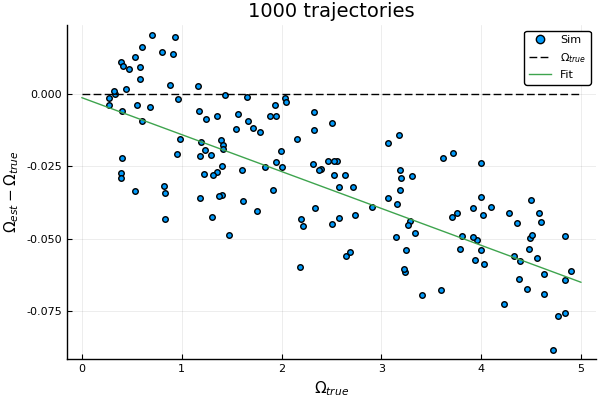

In [97]:
let res = resR1000, omegas = omegasR1000
    processed = collect.(collect(zip(res...)))
    coeff = linreg(omegas, processed[1] - omegas)
    scatter(omegas, (processed[1] .- omegas), label="Sim")
    plot!([0,5],[0,0], style=:dash, color=:black, label=L"\Omega_{true}")
    plot!([0,5], coeff[2] .* [0,5] .- coeff[1], label="Fit")
    xlabel!(L"\Omega_{true}")
    ylabel!(L"\Omega_{est}- \Omega_{true}")
    title!("1000 trajectories")
end

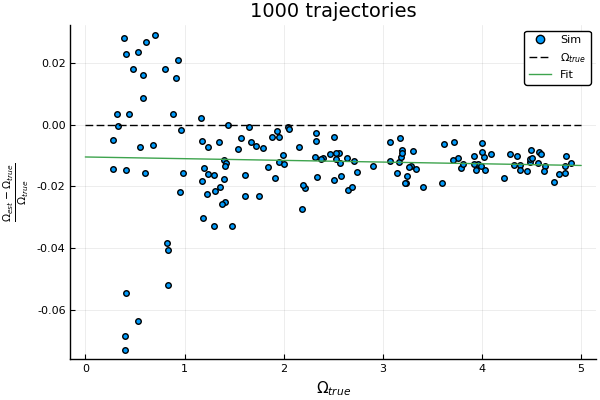

In [101]:
let res = resR1000, omegas = omegasR1000
    processed = collect.(collect(zip(res...)))
    coeff = linreg(omegas, (processed[1] .- omegas) ./ omegas )
    scatter(omegas, (processed[1] .- omegas) ./omegas, label="Sim")
    plot!([0,5],[0,0], style=:dash, color=:black, label=L"\Omega_{true}")
    plot!([0,5], coeff[2] .* [0,5] .+ coeff[1], label="Fit")
    xlabel!(L"\Omega_{true}")
    ylabel!(L"\frac{\Omega_{est}- \Omega_{true}}{\Omega_{true}}")
    title!("1000 trajectories")
end

In [106]:
omegasR10002 = rand(0.25:0.00001:5, 150)
@time resR10002 = pmap(o -> vsomega(o, 1000, params), omegasR10002, batch_size=10)

1089.408997 seconds (97.23 k allocations: 4.337 MiB, 0.01% gc time)


150-element Array{Tuple{Float64,Float64},1}:
 (0.6282048542508105, 0.01419827111411222) 
 (3.756525836777347, 0.013152408349231828) 
 (1.6971279827429826, 0.01405432139922552) 
 (4.28643419578648, 0.015237931065332335)  
 (4.278246198363833, 0.013715857928636626) 
 (1.1744717596838017, 0.013927689013801973)
 (4.7769179508203505, 0.013411639621191898)
 (3.543425921213837, 0.016873611367316455) 
 (3.67396536515819, 0.015096735145815762)  
 (2.4573398614434256, 0.013837505368530099)
 (4.279438333149913, 0.014217066446865533) 
 (4.460888666025225, 0.013839232634666868) 
 (4.209854840561221, 0.013297240970970918) 
 ⋮                                         
 (1.8876607978323667, 0.01467987926720072) 
 (1.3529769489906576, 0.014915288045993803)
 (2.4603829093678256, 0.013684728842021699)
 (0.4513358592339715, 0.012000160567425441)
 (0.8122402486655511, 0.013685306847785728)
 (1.3159627056351577, 0.014057552518146542)
 (3.1553704598312704, 0.013917214458937913)
 (2.0114819412556177, 0.0148320

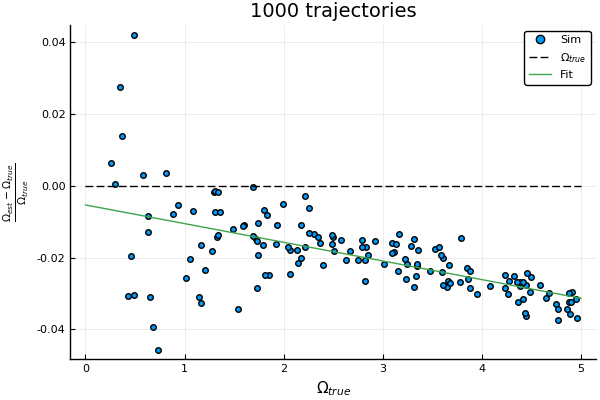

In [107]:
let res = resR10002, omegas = omegasR10002
    processed = collect.(collect(zip(res...)))
    coeff = linreg(omegas, (processed[1] .- omegas) ./ omegas )
    scatter(omegas, (processed[1] .- omegas) ./omegas, label="Sim")
    plot!([0,5],[0,0], style=:dash, color=:black, label=L"\Omega_{true}")
    plot!([0,5], coeff[2] .* [0,5] .+ coeff[1], label="Fit")
    xlabel!(L"\Omega_{true}")
    ylabel!(L"\frac{\Omega_{est}- \Omega_{true}}{\Omega_{true}}")
    title!("1000 trajectories")
end

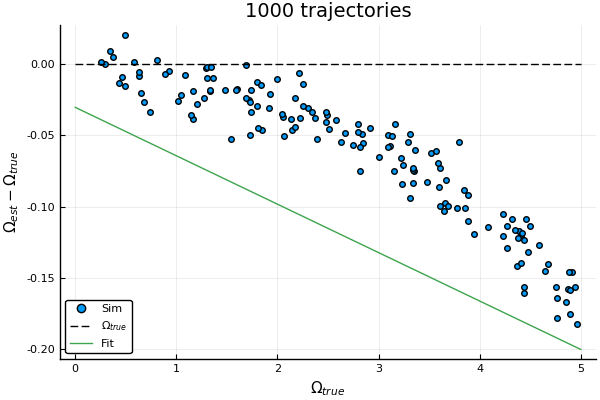

In [108]:
let res = resR10002, omegas = omegasR10002
    processed = collect.(collect(zip(res...)))
    coeff = linreg(omegas, processed[1] - omegas)
    scatter(omegas, (processed[1] .- omegas), label="Sim")
    plot!([0,5],[0,0], style=:dash, color=:black, label=L"\Omega_{true}")
    plot!([0,5], coeff[2] .* [0,5] .- coeff[1], label="Fit")
    xlabel!(L"\Omega_{true}")
    ylabel!(L"\Omega_{est}- \Omega_{true}")
    title!("1000 trajectories")
end